In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [1]:
import numpy as np
import pandas as pd
import cmath
from numpy import pi

def generate_data(samples_number):
    mu, sigma = np.random.uniform(-2,2,1), 0.3
    real = np.random.normal(mu, sigma, samples_number)
    mu, sigma = np.random.uniform(-2,2,1), 0.3
    imag = np.random.normal(mu, sigma, samples_number)
    return np.stack((real, imag), axis=-1)

In [2]:
class1 = pd.DataFrame(generate_data(100), columns = ['Real', 'Imaginary'])
class1['Class'] = 1
class2 = pd.DataFrame(generate_data(100), columns = ['Real', 'Imaginary'])
class2['Class'] = 2

In [3]:
data = pd.concat([class1, class2])

In [4]:
data['Class_Real'] = data['Class'].apply(lambda x: 1 if x == 1 else -1)
data['Class_Imaginary'] = 0

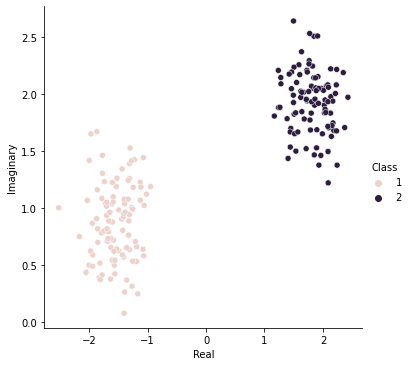

In [5]:
import seaborn as sns

sns.relplot(x="Real", y="Imaginary", hue="Class", data=data);

In [194]:
from sklearn.model_selection import train_test_split
np.random.seed(12345)

# сделать w_0

data_r = np.random.uniform(-2,2,10000)
data_i = np.random.uniform(-4,4,10000)
data_new = np.array(list(map(lambda x, y: complex(x,y), data_r, data_i)))

#data_new = np.append(np.ones(1000) + 1j, data_new, 0)
data_new = data_new.reshape(10, 1000)
data_w = pd.DataFrame(data_new).T


condition_r = abs(data_w[3] + data_w[7] / data_w[6] ** 2 - data_w[1]) >= 3
condition_i = abs(data_w[3]**3 - data_w[7] * data_w[6] * 2 + data_w[1] / data_w[8]) >= 13

# condition_r = abs(data_w[3] + data_w[7]) >= 3
# condition_i = abs(data_w[4] - 2 * data_w[2]) <= 6

y_r = np.where(condition_r, -1, 1)

y_i = np.where(condition_i, -1, 1)

data_w['y'] = np.array(list(map(lambda x, y: complex(x,y), y_r, y_i)))
X = data_w.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data_w['y'], test_size=0.3, random_state=10)

In [195]:
x_R = np.real(X_train).T
x_I = np.imag(X_train).T
y_R = np.real(y_train)
y_I = np.imag(y_train)

## CVXOPT

In [196]:
#!pip install cvxopt
from cvxopt import solvers
from cvxopt import matrix

In [197]:
# multiplires_guess = np.random.normal(1, 1, len(data) * 2)
# y_R = np.matrix(data["Class_Real"].to_numpy())
# y_I = np.matrix(data["Class_Imaginary"].to_numpy())
# x_R = np.matrix(data["Real"].to_numpy())
# x_I = np.matrix(data["Imaginary"].to_numpy())

In [198]:
l = len(X_train)
lamda = 0.2
H_RR = x_R.T @ x_R
H_II = x_I.T @ x_I
H_RI = x_R.T @ x_I
H_IR = x_I.T @ x_R
H = np.block([[H_RR + H_II, H_RI - H_IR], [H_IR - H_RI, H_RR + H_II]])
# Y = np.block([[np.diag(y_R.A1), np.zeros((l,l))],[np.zeros((l,l)), np.diag(y_I.A1)]])
Y = np.block([[np.diag(y_R), np.zeros((l,l))], [np.zeros((l,l)), np.diag(y_I)]])
P = Y @ H @ Y

In [199]:
q = -np.ones((2*l, 1))
G = np.block([[-np.identity(2*l)], [np.identity(2*l)]])
h = np.block([[np.zeros((2*l, 1))], [lamda * np.ones((2*l, 1))]])
A = np.block([[y_R, np.zeros(l)], [np.zeros(l), y_I]])
b = np.array([0,0])
#A = np.block([[y_R, np.zeros(l)]])
#b = np.array([0])

In [200]:
P = matrix(P)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A)
b = matrix(b, tc='d')

sol = solvers.qp(P,q,G,h,A,b)

     pcost       dcost       gap    pres   dres
 0: -7.4815e+02 -6.5396e+02  9e+03  1e+01  2e-13
 1: -1.9688e+02 -6.0143e+02  7e+02  4e-01  2e-13
 2: -1.9066e+02 -2.4626e+02  6e+01  7e-03  7e-14
 3: -1.9800e+02 -2.0777e+02  1e+01  7e-04  7e-14
 4: -1.9919e+02 -1.9929e+02  1e-01  8e-06  7e-14
 5: -1.9920e+02 -1.9920e+02  1e-03  8e-08  7e-14
 6: -1.9920e+02 -1.9920e+02  1e-05  8e-10  7e-14
Optimal solution found.


In [201]:
alphas = np.array(sol['x']).reshape(-1)
a_R = alphas[:l]
a_I = alphas[l:]

In [202]:
x_R.shape

(10, 700)

In [203]:
a_R = alphas[:l]
a_I = alphas[l:]

In [204]:
x_R.shape

(10, 700)

In [205]:
a_R.shape

(700,)

In [206]:
w_R = (y_R * a_R * x_R).sum(axis=1) + (y_I * a_I * x_I).sum(axis=1)
w_I = (y_R * a_R * x_I).sum(axis=1) - (y_I * a_I * x_R).sum(axis=1)

In [207]:
sv_R = np.where((a_R > 0) & (a_R < lamda))[0]
sv_I = np.where((a_I > 0) & (a_I < lamda))[0]

In [208]:
b_R = (y_R[sv_R] - w_R @ x_R[:, sv_R] - w_I @ x_I[:, sv_R]).sum() / len(sv_R)
b_I = (y_I[sv_I] - w_R @ x_I[:, sv_I] + w_I @ x_R[:, sv_I]).sum() / len(sv_I)

$\sum_{j=1}^{l}\left(\alpha_{j} \circ y_{j}\right)\left(\mathbf{x}_{j}^{H} \mathbf{x}\right)+b = \sum_{j=1}^{l} [\operatorname{Re}(\alpha_{j}) \operatorname{Re}(y_j)+i \operatorname{Im}(\alpha_{j}) \operatorname{Im}(y_j) ](\mathbf{x}_{j}^{H} \mathbf{x})+b$ 

In [209]:
y_pred = np.zeros(len(X_test),dtype=np.complex_)

for i in range(len(X_train)):
    y_pred += np.complex(a_R[i] * y_R[i], a_I[i] * y_I[i]) \
    * np.conj(X_train.iloc[i]) @ X_test.T + np.complex(b_R, b_I)
    
y_pred_fin_= np.zeros(len(X_test),dtype=np.complex_)
y_pred_fin_.real = np.sign(np.real(y_pred))
y_pred_fin_.imag = np.sign(np.imag(y_pred))

/var/folders/5b/j4k5qtvx2j7b9nzkp2clls4c0000gp/T/ipykernel_36148/835742473.py:4: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred += np.complex(a_R[i] * y_R[i], a_I[i] * y_I[i]) \
/var/folders/5b/j4k5qtvx2j7b9nzkp2clls4c0000gp/T/ipykernel_36148/835742473.py:5: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  * np.conj(X

In [222]:
def to_degrees(z):
    return np.degrees(cmath.phase(z) + 2 * pi) % 360

def class_definder(coordinate):
    answer = to_degrees(coordinate)
    if answer >= 0 and answer < 90:
        return 1+1j
    elif answer >= 90 and answer < 180:
        return -1+1j
    elif answer >= 180 and answer < 270:
        return -1-1j
    else :
        return 1-1j

In [223]:
y_pred_fin = []
for element in y_pred:
    y_pred_fin.append(class_definder(element))    

In [224]:
(y_pred_fin - y_test).value_counts()

0j         115
(-2+0j)     88
-2j         54
(-2-2j)     43
Name: y, dtype: int64

In [225]:
(y_pred_fin_ - y_test).value_counts()

0j         115
(-2+0j)     88
-2j         54
(-2-2j)     43
Name: y, dtype: int64

In [214]:
115 / 300

0.38333333333333336